<a href="https://colab.research.google.com/github/MahaswetaTalik/DEEP_LEARNING/blob/main/Encoder_Decoder_(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

In [2]:
# 1. Sample Data

input_texts = ['hello', 'world', 'data', 'visual']
target_texts = ['olleh', 'dlrow', 'atad', 'lausiv']

# Add start and end tokens to target sequences
target_texts = ['\t' + text + '\n' for text in target_texts]

# Create character sets
input_chars = sorted(set(''.join(input_texts)))
target_chars = sorted(set(''.join(target_texts)))

input_token_index = {char: i for i, char in enumerate(input_chars)}
target_token_index = {char: i for i, char in enumerate(target_chars)}

# Reverse lookup
reverse_target_char_index = {i: char for char, i in target_token_index.items()}

max_encoder_seq_length = max(len(txt) for txt in input_texts)
max_decoder_seq_length = max(len(txt) for txt in target_texts)

num_encoder_tokens = len(input_chars)
num_decoder_tokens = len(target_chars)

In [3]:
# 2. Vectorize Data

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

In [4]:
# 3. Define Encoder

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(256, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

In [5]:
# 4. Define Decoder

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [6]:
# 5. Compile and Train

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=2, epochs=300)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.1042 - loss: 1.9718
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2292 - loss: 2.0514 
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2500 - loss: 1.9140 
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2708 - loss: 1.9934
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2708 - loss: 1.8532
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2500 - loss: 1.7964
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2500 - loss: 1.7355
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2708 - loss: 1.7909
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2292 - loss: 1.6585
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2292 - loss: 1.6411
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2708 - loss: 1.6525
Epoch 12/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2708 - 

In [7]:
# 6. Inference Models

# Encoder model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [8]:
# 7. Decode Function

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.0

    decoded_sentence = ''
    while True:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        if sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length:
            break
        decoded_sentence += sampled_char
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

In [9]:
# 8. Test It

for seq_index in range(len(input_texts)):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded = decode_sequence(input_seq)
    print(f"{input_texts[seq_index]} → {decoded}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
hello → olleh
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
world → dlrow
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
data → atad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━

In [11]:
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=2,
    epochs=300
)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7708 - loss: 0.1189
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7292 - loss: 0.1453
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7708 - loss: 0.1238
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7708 - loss: 0.1229
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7500 - loss: 0.1260
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7708 - loss: 0.1237
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7292 - loss: 0.1259
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7500 - loss: 0.1335
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7500 - loss: 0.1244
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7708 - loss: 0.1232 
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7500 - loss: 0.1241
Epoch 12/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7500 

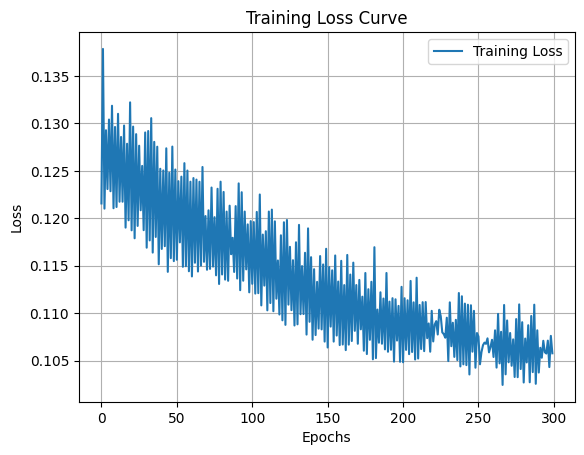

In [12]:
# Training Loss curve

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

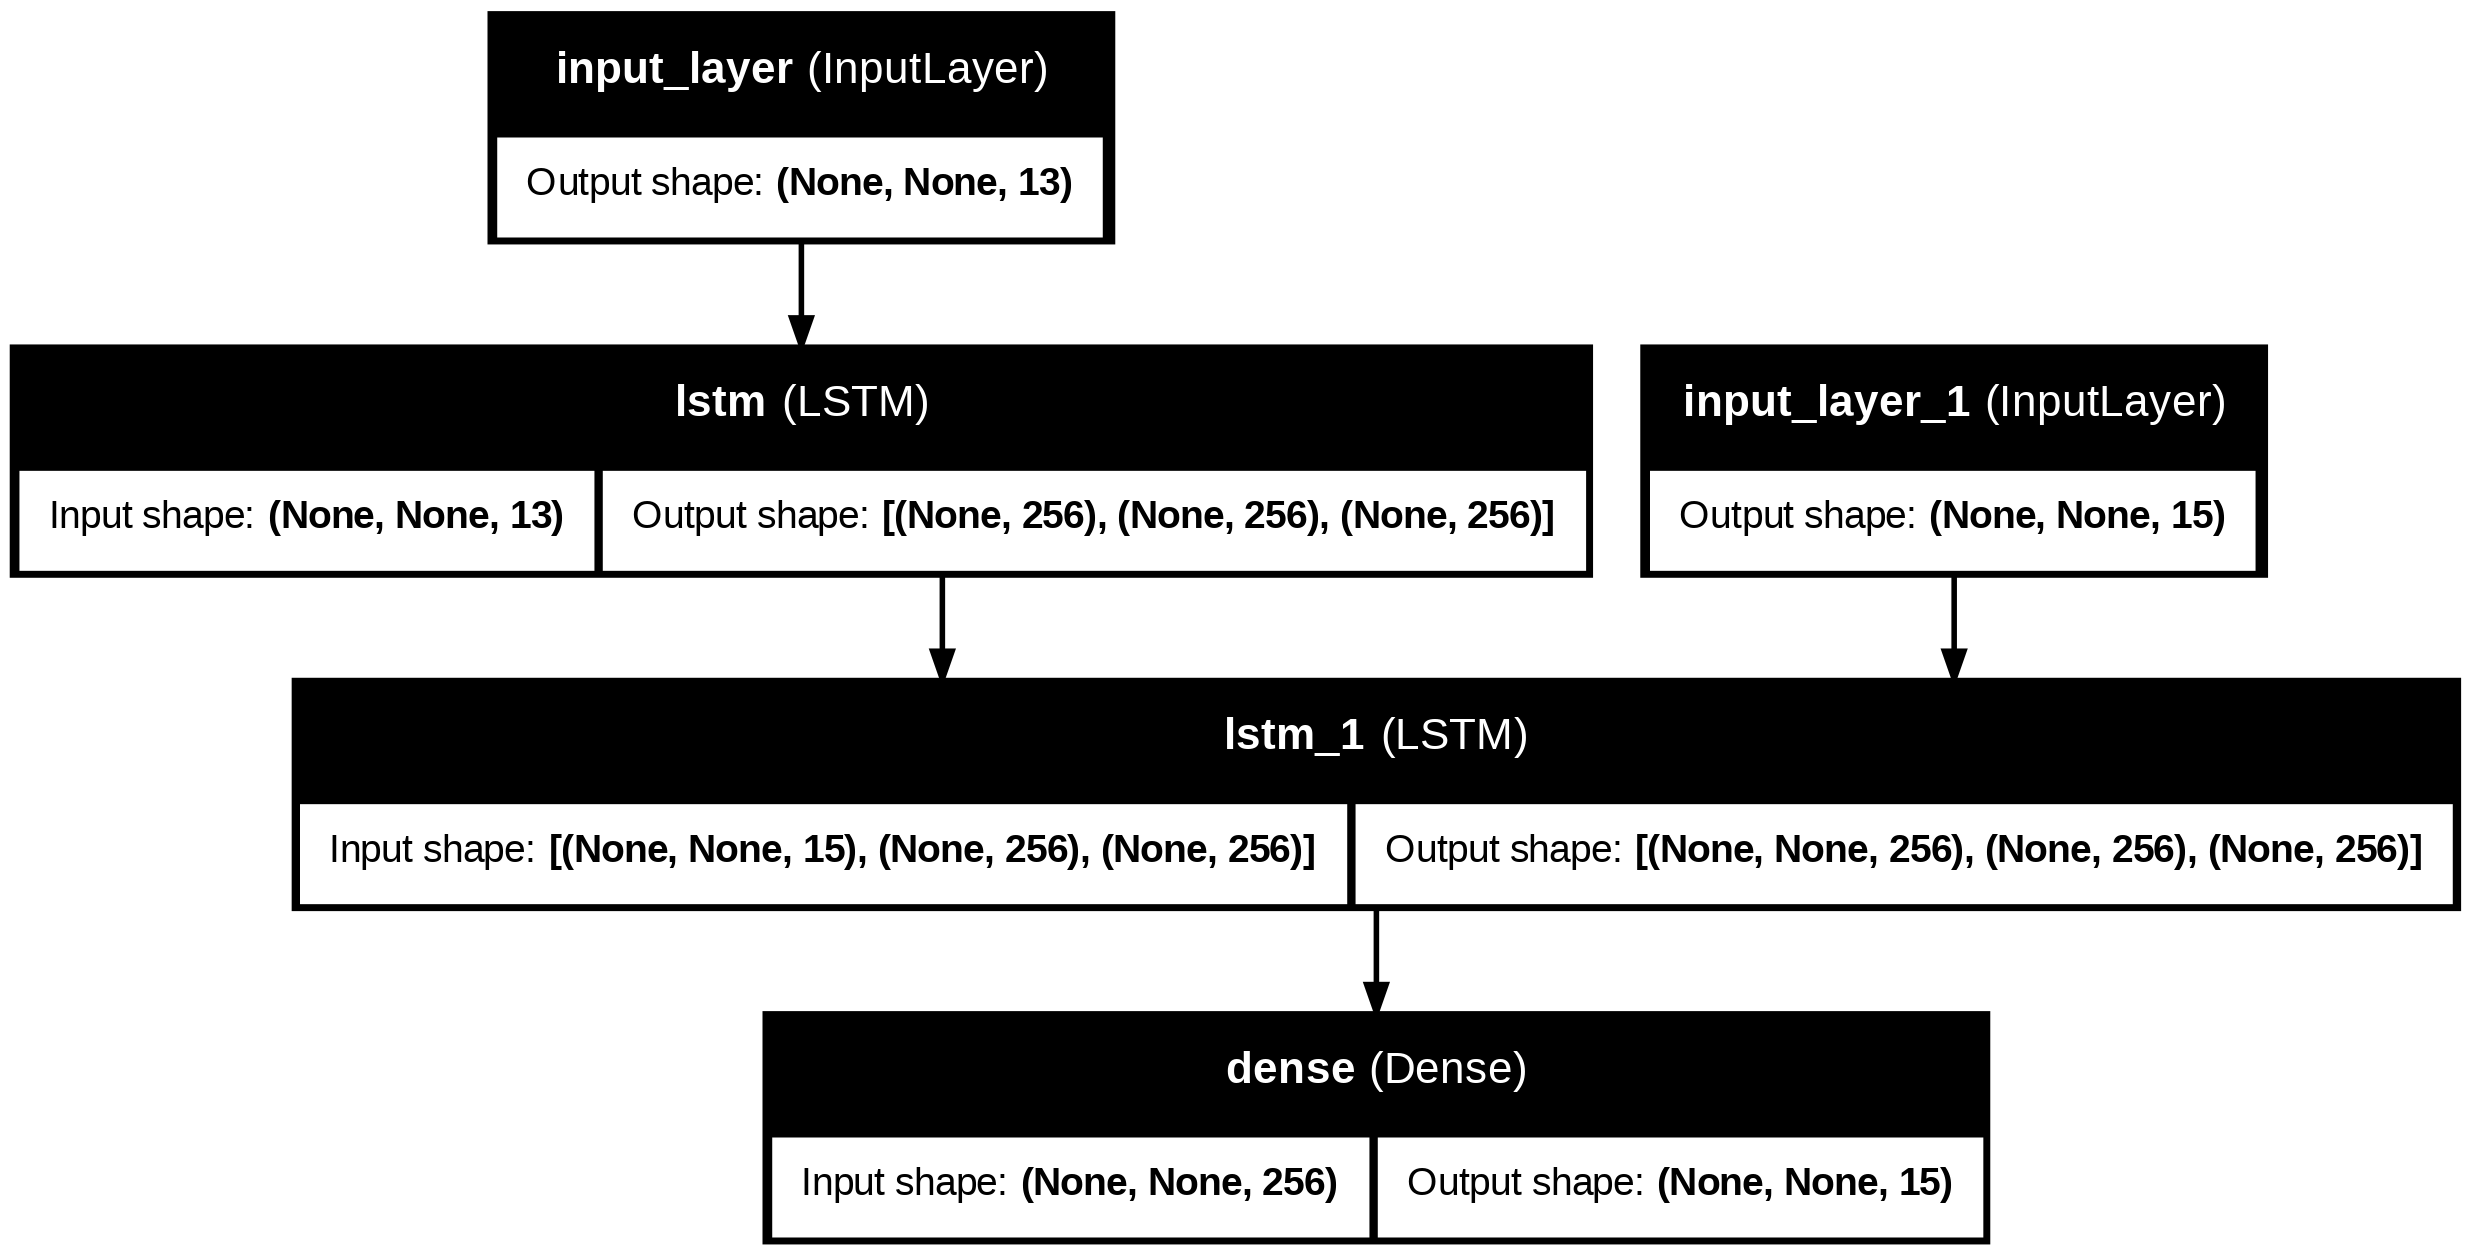

In [14]:
# Model Architecture

from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)